In [1]:
from google.colab import drive
drive.mount('/content/drive')

zip_path_train = 'drive/My Drive/Project/Human Action Recognition/Train/train.zip'
zip_path_test  = 'drive/My Drive/Project/Human Action Recognition/Train/test.zip'

Mounted at /content/drive


In [2]:
from zipfile import ZipFile

with ZipFile(zip_path_train, 'r') as zipObj:
    zipObj.extractall('train')

with ZipFile(zip_path_test, 'r') as zipObj:
    zipObj.extractall('test')

In [3]:
!pip uninstall jax

Found existing installation: jax 0.4.8
Uninstalling jax-0.4.8:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/jax-0.4.8.dist-info/*
    /usr/local/lib/python3.10/dist-packages/jax/*
Proceed (Y/n)? Y
  Successfully uninstalled jax-0.4.8


In [4]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 27.7 MB/s eta 0:00:00


In [7]:
import os
import glob
import random
import numpy as np
import pandas as pd
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import matplotlib.image as img
import matplotlib.pyplot as plt
import plotly.express as px
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from pathlib import Path
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [8]:
train_fol = glob.glob("/content/train/train/*") 
test_fol = glob.glob("/content/test/test/*")

In [9]:
train_csv = pd.read_csv("drive/My Drive/Project/Human Action Recognition/Training_set.csv")
test_csv = pd.read_csv("drive/My Drive/Project/Human Action Recognition/Testing_set.csv")

In [10]:
filename = train_csv['filename']
label = train_csv['label']

In [11]:
# Loading the image and converting it to numpy array of size(160,160)

img_data = []
img_label = []
length = len(train_fol)
for i in (range(len(train_fol)-1)):
    t = '/content/train/train/' + filename[i]    
    temp_img = Image.open(t)
    img_data.append(np.asarray(temp_img.resize((160,160))))
    img_label.append(label[i])

In [12]:
iii = img_data
iii = np.asarray(iii)
type(iii)

numpy.ndarray

In [13]:
# The training labels are label encoded
y_train = to_categorical(np.asarray(train_csv['label'].factorize()[0]))

In [14]:
# Test and train split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(iii, y_train, test_size=0.2)

In [15]:
# Load the pre-trained ResNet50 model with imagenet weights
base_model = ResNet50(include_top=False,
                   input_shape=(160,160,3),
                   pooling='max',classes=15,
                   weights='imagenet')

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(15, activation='softmax'))


# Compile the model with appropriate optimizer and loss function
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 15)                7695      
                                                                 
Total params: 24,644,495
Trainable params: 1,056,783
Non-trainable params: 23,587,712
_________________________________________________________________


In [16]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# Create an ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function=preprocess_input,
    featurewise_center=True,
    featurewise_std_normalization=True)

# Create training and validation generators
train_generator = datagen.flow(x_train, y_train, batch_size=32, subset='training')
val_generator = datagen.flow(x_train, y_train, batch_size=32, subset='validation')
test_generator = datagen.flow(x_test, y_test, batch_size=32)

# Train the model in batches using the generators
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=60,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[tl_checkpoint_1, early_stop],
    verbose=1)

<ipython-input-16-4395ff09098e>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/60
252/252 [==============================] - ETA: 0s - loss: 3.5249 - accuracy: 0.3999
Epoch 1: val_loss improved from inf to 1.59969, saving model to tl_model_v1.weights.best.hdf5
252/252 [==============================] - 68s 231ms/step - loss: 3.5249 - accuracy: 0.3999 - val_loss: 1.5997 - val_accuracy: 0.4901
Epoch 2/60
252/252 [==============================] - ETA: 0s - loss: 1.4891 - accuracy: 0.5182
Epoch 2: val_loss improved from 1.59969 to 1.48863, saving model to tl_model_v1.weights.best.hdf5
252/252 [==============================] - 55s 218ms/step - loss: 1.4891 - accuracy: 0.5182 - val_loss: 1.4886 - val_accuracy: 0.5298
Epoch 3/60
252/252 [==============================] - ETA: 0s - loss: 1.3479 - accuracy: 0.5663
Epoch 3: val_loss improved from 1.48863 to 1.33324, saving model to tl_model_v1.weights.best.hdf5
252/252 [==============================] - 55s 220ms/step - loss: 1.3479 - accuracy: 0.5663 - val_loss: 1.3332 - val_accuracy: 0.5794
Epoch 4/60
252/252 [

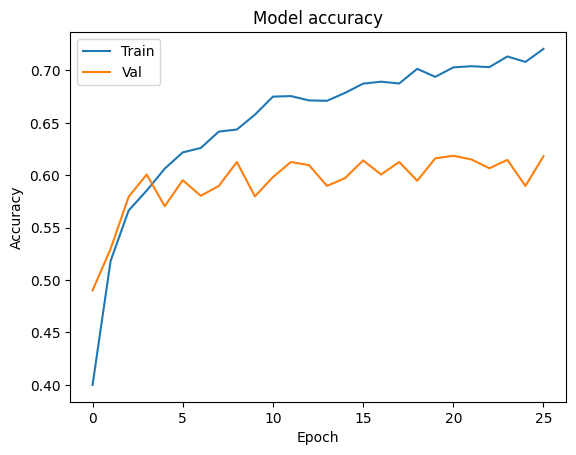

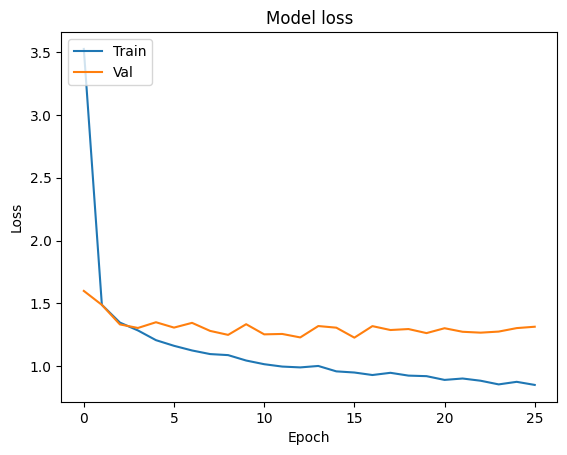

In [17]:
# Get the training and validation accuracy and loss values from the history object
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot the training and validation accuracy values
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot the training and validation loss values
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [18]:
true_classes = np.array([])
for i in range(len(test_generator)):
    batch = test_generator[i]
    labels = batch[1]
    true_classes = np.concatenate((true_classes, np.argmax(labels, axis=1)))


vgg_preds = model.predict(test_generator)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)


vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))
print("Classification Report:\n")
print(classification_report(true_classes, vgg_pred_classes))

79/79 [==============================] - 15s 178ms/step
VGG16 Model Accuracy without Fine-Tuning: 61.03%
Classification Report:

              precision    recall  f1-score   support

         0.0       0.51      0.58      0.54       171
         1.0       0.74      0.51      0.60       167
         2.0       0.60      0.60      0.60       150
         3.0       0.76      0.73      0.74       178
         4.0       0.58      0.66      0.62       167
         5.0       0.70      0.61      0.65       180
         6.0       0.89      0.46      0.61       166
         7.0       0.96      0.84      0.89       183
         8.0       0.35      0.48      0.41       173
         9.0       0.63      0.68      0.65       182
        10.0       0.80      0.70      0.75       176
        11.0       0.56      0.73      0.63       128
        12.0       0.39      0.34      0.36       170
        13.0       0.61      0.84      0.71       160
        14.0       0.39      0.40      0.40       169

    a

[[ 99   6   4   6   3   6   1   0  10   2   9   6   5   8   6]
 [ 17  85   5   6   3   0   0   0  19   4   3   0   9   1  15]
 [  5   2  90   5   3   1   0   1   9  12   0   7   9   2   4]
 [ 13   3  10 130   4   0   0   0   4   2   0   6   1   1   4]
 [  2   1   5   2 111   2   0   0  11   4   5   4   7   2  11]
 [ 15   1   5   0   4 110   1   0   6  12   4   4   5   3  10]
 [  2   0   2   3   2  10  77   0   9   1   2  26   1  29   2]
 [  5   0   1   0   0   1   1 153   2   1   0   4   1  14   0]
 [ 10   5   5   3  10   6   0   0  83  10   1   0  25   3  12]
 [  2   0   8   2   9   2   0   0  14 123   1   1   9   1  10]
 [  8   3   0   2  12  10   0   0   4   1 124   3   0   1   8]
 [  1   0   4   3   1   3   4   0   1   0   1  93   1  15   1]
 [  7   3   4   4  14   2   1   0  38  16   0   0  58   3  20]
 [  3   0   0   0   0   1   1   5   4   0   0   9   2 135   0]
 [  5   6   8   6  15   3   1   0  22   8   5   4  15   4  67]]


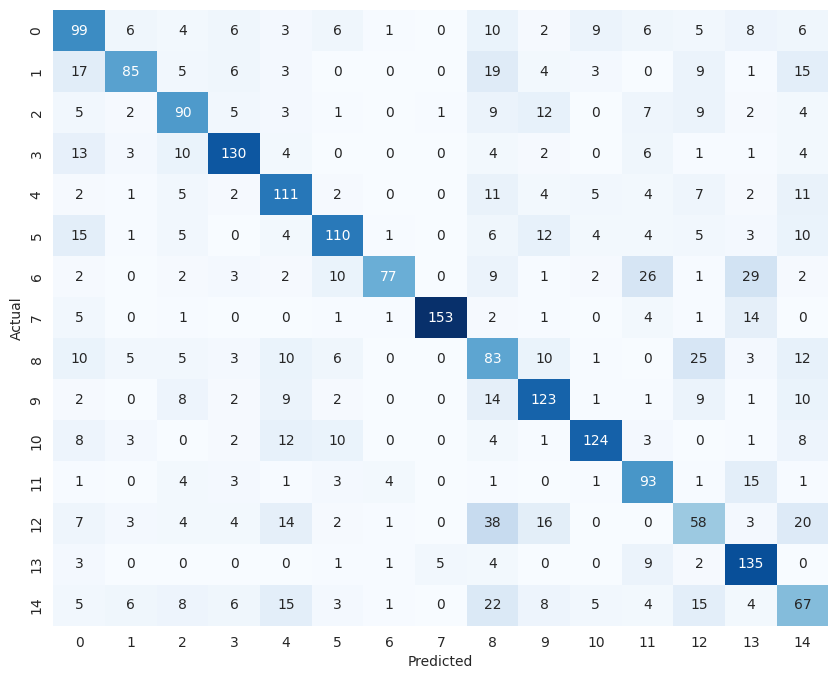

Area Under the ROC Curve: 0.9366410431555091


In [19]:
cm = confusion_matrix(true_classes, vgg_pred_classes)
print(cm)
# Plot confusion matrix
sns.set_style('white')
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate ROC AUC score
roc_auc = roc_auc_score(true_classes, vgg_preds, multi_class='ovr')
print("Area Under the ROC Curve:", roc_auc)

In [21]:
# Create lists to store true positives, false positives, true negatives, and false negatives for each class
tp_list = []
fp_list = []
tn_list = []
fn_list = []

# Loop through each class
for i in range(cm.shape[0]):
    # Calculate true positives
    tp = cm[i,i]
    # Calculate false positives
    fp = np.sum(cm[:,i]) - tp
    # Calculate true negatives
    tn = np.sum(cm) - tp - fp - np.sum(cm[i,:])
    # Calculate false negatives
    fn = np.sum(cm[i,:]) - tp
    # Append values to lists
    tp_list.append(tp)
    fp_list.append(fp)
    tn_list.append(tn)
    fn_list.append(fn)

# Calculate true positive rate (TPR) and false positive rate (FPR) for each class
tpr_list = np.array(tp_list) / (np.array(tp_list) + np.array(fn_list))
fpr_list = np.array(fp_list) / (np.array(fp_list) + np.array(tn_list))

for i in range(0,15):
  print("TPR of class:"+str(i)+" is "+str(tpr_list[i]))

for i in range(0,15):
  print("FPR of class:"+str(i)+" is "+str(fpr_list[i]))

TPR of class:0 is 0.5789473684210527
TPR of class:1 is 0.5089820359281437
TPR of class:2 is 0.6
TPR of class:3 is 0.7303370786516854
TPR of class:4 is 0.6646706586826348
TPR of class:5 is 0.6111111111111112
TPR of class:6 is 0.463855421686747
TPR of class:7 is 0.8360655737704918
TPR of class:8 is 0.4797687861271676
TPR of class:9 is 0.6758241758241759
TPR of class:10 is 0.7045454545454546
TPR of class:11 is 0.7265625
TPR of class:12 is 0.3411764705882353
TPR of class:13 is 0.84375
TPR of class:14 is 0.39644970414201186
FPR of class:0 is 0.042222222222222223
FPR of class:1 is 0.013227513227513227
FPR of class:2 is 0.02675438596491228
FPR of class:3 is 0.0189873417721519
FPR of class:4 is 0.03568242640499554
FPR of class:5 is 0.021076233183856503
FPR of class:6 is 0.004391743522178305
FPR of class:7 is 0.0027472527472527475
FPR of class:8 is 0.06757950530035335
FPR of class:9 is 0.03295711060948081
FPR of class:10 is 0.013963963963963964
FPR of class:11 is 0.03218790778599391
FPR of clas

In [24]:
# Load the pre-trained ResNet50 model with imagenet weights
base_model = ResNet50(include_top=False,
                   input_shape=(160,160,3),
                   pooling='max',classes=15,
                   weights='imagenet')

# Freeze the layers in the base model
for layer in base_model.layers[:5]:
    layer.trainable = False

# Add new classification layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(15, activation='softmax'))


# Compile the model with appropriate optimizer and loss function
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()





Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dense_5 (Dense)             (None, 15)                7695      
                                                                 
Total params: 24,644,495
Trainable params: 24,581,775
Non-trainable params: 62,720
_________________________________________________________________


In [25]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# Create an ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function=preprocess_input,
    featurewise_center=True,
    featurewise_std_normalization=True)

# Create training and validation generators
train_generator = datagen.flow(x_train, y_train, batch_size=32, subset='training')
val_generator = datagen.flow(x_train, y_train, batch_size=32, subset='validation')
test_generator = datagen.flow(x_test, y_test, batch_size=32)

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model in batches using the generators
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=60,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[tl_checkpoint_1, early_stop, reduce_lr],
    verbose=1)

<ipython-input-25-d4dcfd59f8a8>:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/60
252/252 [==============================] - ETA: 0s - loss: 3.1362 - accuracy: 0.2160
Epoch 1: val_loss improved from inf to 2.42440, saving model to tl_model_v1.weights.best.hdf5
252/252 [==============================] - 69s 250ms/step - loss: 3.1362 - accuracy: 0.2160 - val_loss: 2.4244 - val_accuracy: 0.2450 - lr: 0.0010
Epoch 2/60
252/252 [==============================] - ETA: 0s - loss: 2.0133 - accuracy: 0.3428
Epoch 2: val_loss improved from 2.42440 to 1.94376, saving model to tl_model_v1.weights.best.hdf5
252/252 [==============================] - 61s 242ms/step - loss: 2.0133 - accuracy: 0.3428 - val_loss: 1.9438 - val_accuracy: 0.3760 - lr: 0.0010
Epoch 3/60
252/252 [==============================] - ETA: 0s - loss: 1.8707 - accuracy: 0.3917
Epoch 3: val_loss did not improve from 1.94376
252/252 [==============================] - 60s 236ms/step - loss: 1.8707 - accuracy: 0.3917 - val_loss: 2.3483 - val_accuracy: 0.2808 - lr: 0.0010
Epoch 4/60
252/252 [============

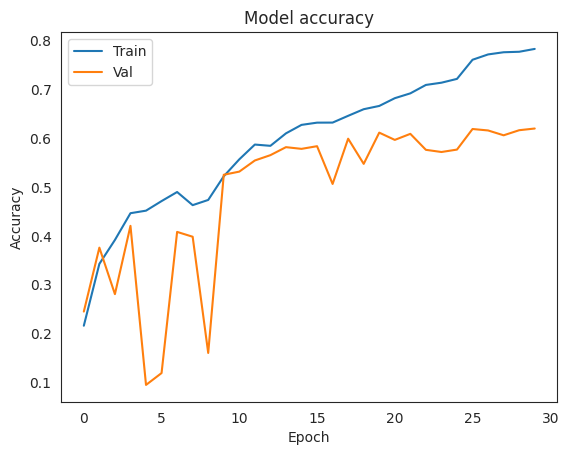

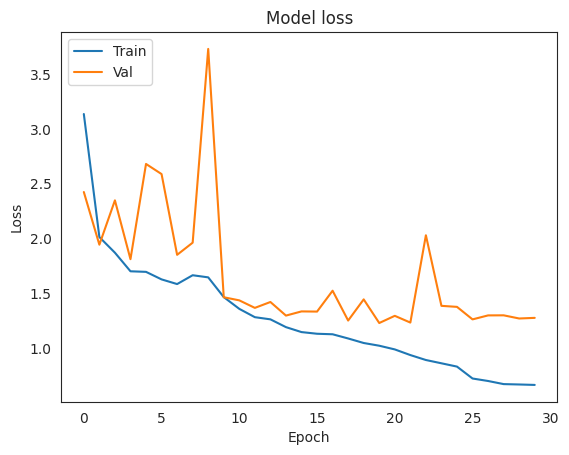

In [26]:
# Get the training and validation accuracy and loss values from the history object
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot the training and validation accuracy values
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot the training and validation loss values
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [33]:
true_classes = np.array([])
for i in range(len(test_generator)):
    batch = test_generator[i]
    labels = batch[1]
    true_classes = np.concatenate((true_classes, np.argmax(labels, axis=1)))

vgg_preds = model.predict(test_generator)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)


vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc * 100))
print("Classification Report:\n")
print(classification_report(true_classes, vgg_pred_classes))

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


79/79 [==============================] - 13s 169ms/step
VGG16 Model Accuracy with Fine-Tuning: 61.43%
Classification Report:

              precision    recall  f1-score   support

         0.0       0.52      0.42      0.47       171
         1.0       0.48      0.51      0.50       167
         2.0       0.62      0.73      0.67       150
         3.0       0.69      0.73      0.71       178
         4.0       0.52      0.51      0.52       167
         5.0       0.69      0.54      0.61       180
         6.0       0.57      0.61      0.59       166
         7.0       0.88      0.92      0.90       183
         8.0       0.52      0.49      0.50       173
         9.0       0.81      0.66      0.73       182
        10.0       0.74      0.81      0.77       176
        11.0       0.57      0.57      0.57       128
        12.0       0.57      0.42      0.48       170
        13.0       0.64      0.80      0.71       160
        14.0       0.39      0.47      0.42       169

    accu

[[ 77  14   8   6   1  11   5   6   4   0   8   7   5  11   8]
 [ 19  84   6   5   5   0   1   1  12   1   1   4   8   3  17]
 [  5   6 110   4   5   0   1   0   1   2   1   1   5   3   6]
 [  8   2   9 133   1   1   3   2   4   1   0   3   1   0  10]
 [  6  11   5   9  79   4   5   2   2   4  11   3   4   1  21]
 [  9   4   5   2  16  89  16   0   4   5   8   9   3   3   7]
 [  3   4   2   1   1   7 104   2   2   0   2  14   6  17   1]
 [  1   0   0   0   0   3   5 160   0   0   1   1   2   9   1]
 [  9  19   4   2   8   3   5   1  90   9   3   2  11   1   6]
 [  1   2   8   1  16   4   2   0   6 127   1   2   2   1   9]
 [  2   3   1   0   8   5   4   1   1   0 144   1   1   0   5]
 [  5   0   2   8   1   5  11   0   2   0   0  78   1  13   2]
 [  5   7   8   3   6   3   1   0  25  10   1   1  69   4  27]
 [  5   1   2   0   1   2  11   4   1   0   3   6   1 121   2]
 [  4  15  11   6   9   7   6   3  11   1   3   2  10   5  76]]


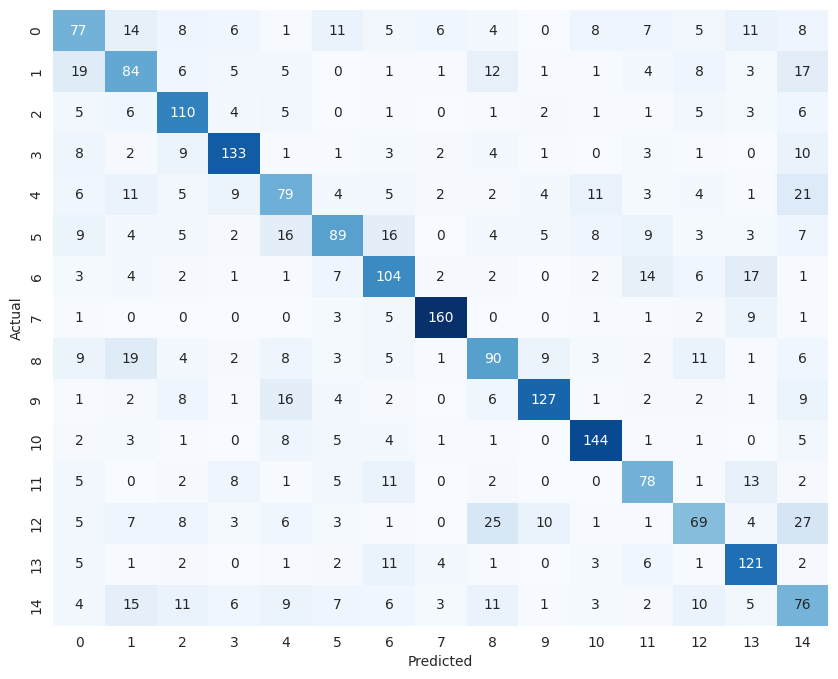

Area Under the ROC Curve: 0.9317507277147178


In [31]:
cm = confusion_matrix(true_classes, vgg_pred_classes)
print(cm)
# Plot confusion matrix
sns.set_style('white')
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate ROC AUC score
roc_auc = roc_auc_score(true_classes, vgg_preds, multi_class='ovr')
print("Area Under the ROC Curve:", roc_auc)

In [32]:
# Create lists to store true positives, false positives, true negatives, and false negatives for each class
tp_list = []
fp_list = []
tn_list = []
fn_list = []

# Loop through each class
for i in range(cm.shape[0]):
    # Calculate true positives
    tp = cm[i,i]
    # Calculate false positives
    fp = np.sum(cm[:,i]) - tp
    # Calculate true negatives
    tn = np.sum(cm) - tp - fp - np.sum(cm[i,:])
    # Calculate false negatives
    fn = np.sum(cm[i,:]) - tp
    # Append values to lists
    tp_list.append(tp)
    fp_list.append(fp)
    tn_list.append(tn)
    fn_list.append(fn)

# Calculate true positive rate (TPR) and false positive rate (FPR) for each class
tpr_list = np.array(tp_list) / (np.array(tp_list) + np.array(fn_list))
fpr_list = np.array(fp_list) / (np.array(fp_list) + np.array(tn_list))

for i in range(0,15):
  print("TPR of class:"+str(i)+" is "+str(tpr_list[i]))

for i in range(0,15):
  print("FPR of class:"+str(i)+" is "+str(fpr_list[i]))

TPR of class:0 is 0.4502923976608187
TPR of class:1 is 0.5029940119760479
TPR of class:2 is 0.7333333333333333
TPR of class:3 is 0.7471910112359551
TPR of class:4 is 0.47305389221556887
TPR of class:5 is 0.49444444444444446
TPR of class:6 is 0.6265060240963856
TPR of class:7 is 0.8743169398907104
TPR of class:8 is 0.5202312138728323
TPR of class:9 is 0.6978021978021978
TPR of class:10 is 0.8181818181818182
TPR of class:11 is 0.609375
TPR of class:12 is 0.40588235294117647
TPR of class:13 is 0.75625
TPR of class:14 is 0.44970414201183434
FPR of class:0 is 0.03609154929577465
FPR of class:1 is 0.03878360511238431
FPR of class:2 is 0.031415929203539826
FPR of class:3 is 0.02127659574468085
FPR of class:4 is 0.03430079155672823
FPR of class:5 is 0.024433585073300755
FPR of class:6 is 0.033777777777777775
FPR of class:7 is 0.010105649977032614
FPR of class:8 is 0.03322995126273815
FPR of class:9 is 0.014925373134328358
FPR of class:10 is 0.019545454545454546
FPR of class:11 is 0.02420051858